## 1. Import Library


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


## 2.Load dataset & Data understanding

Mengambil data historis dari yahoo finance karena menggunakan library yfinance dengan arg max artinya sebanyak mungkin data yang ada dan menampilkan 5 baris data terakhir

In [ ]:
df = yf.Ticker("BBNI.JK")
df = df.history(period="max")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-12-23 00:00:00+07:00,319.488678,344.064720,319.488678,319.488678,853373,0.0,0.0
2003-12-24 00:00:00+07:00,319.488678,319.488678,319.488678,319.488678,0,0.0,0.0
2003-12-25 00:00:00+07:00,319.488678,319.488678,319.488678,319.488678,0,0.0,0.0
2003-12-26 00:00:00+07:00,319.488678,319.488678,319.488678,319.488678,0,0.0,0.0
2003-12-29 00:00:00+07:00,319.488720,337.920746,319.488720,337.920746,319619,0.0,0.0


memvisualisasikan data saham BBNI dalam bentuk candlestick

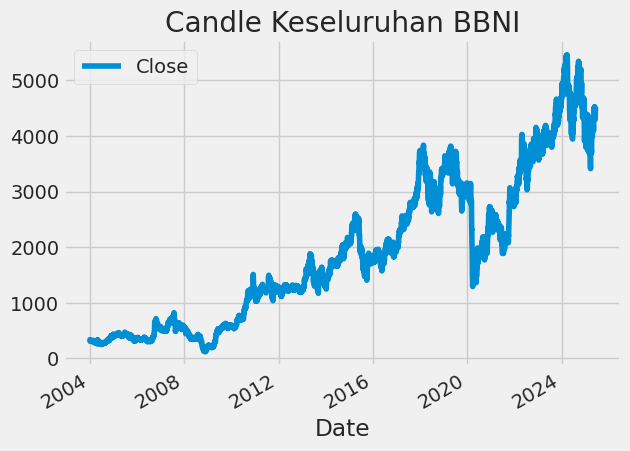

In [ ]:
df.plot.line(y="Close", use_index=True)
plt.title("Candle Keseluruhan BBNI")
plt.show()

mengambil dataframe dari tanggal 1-1-2020 dan seterusnya

In [ ]:
df = df.loc["2020-01-01":"2025-05-25"].copy()

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00+07:00,3127.141867,3127.141867,3087.432129,3087.432129,18602600,0.0,0.0
2020-01-03 00:00:00+07:00,3097.359863,3127.142170,3037.795251,3097.359863,32251400,0.0,0.0
2020-01-06 00:00:00+07:00,3077.504603,3077.504603,3017.939997,3027.867432,26249200,0.0,0.0
2020-01-07 00:00:00+07:00,3047.722626,3057.650061,2988.158014,2998.085449,38049800,0.0,0.0
2020-01-08 00:00:00+07:00,2978.230301,2988.157735,2938.520564,2948.447998,40926800,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1299 entries, 2020-01-02 00:00:00+07:00 to 2025-05-23 00:00:00+07:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1299 non-null   float64
 1   High          1299 non-null   float64
 2   Low           1299 non-null   float64
 3   Close         1299 non-null   float64
 4   Volume        1299 non-null   int64  
 5   Dividends     1299 non-null   float64
 6   Stock Splits  1299 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 81.2 KB


In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1299.000000,1299.000000,1299.000000,1299.000000,1.299000e+03,1299.000000,1299.000000
mean,3433.236129,3474.588359,3385.817218,3428.696198,7.162153e+07,0.807716,0.003079
std,1029.090156,1035.479431,1021.279757,1028.163137,5.134020e+07,14.496883,0.078446
min,1292.781417,1395.058354,1215.050889,1292.781372,0.000000e+00,0.000000,0.000000
25%,2489.723775,2541.583576,2454.648316,2485.331299,3.910900e+07,0.000000,0.000000
50%,3684.247485,3736.729565,3642.261719,3684.247559,5.720760e+07,0.000000,0.000000
75%,4177.971356,4220.000000,4111.697432,4160.667969,8.572665e+07,0.000000,0.000000
max,5460.848145,5483.792800,5414.958581,5460.848145,4.440854e+08,374.057500,2.000000


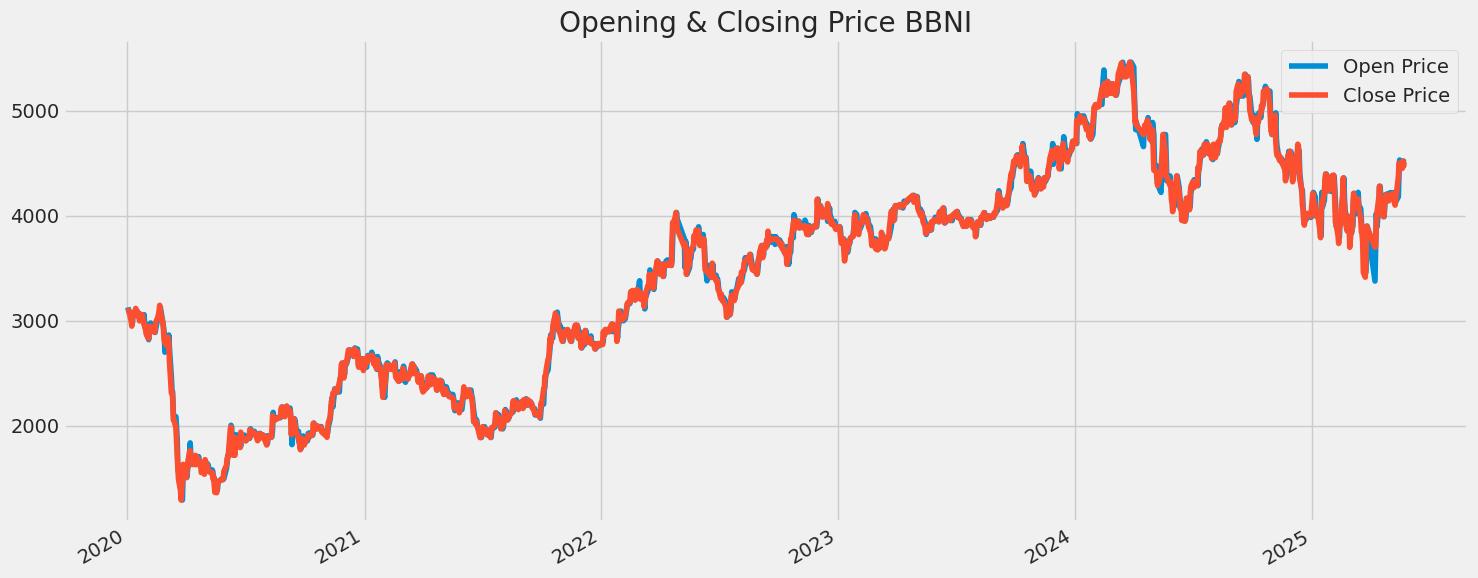

In [ ]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price BBNI")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

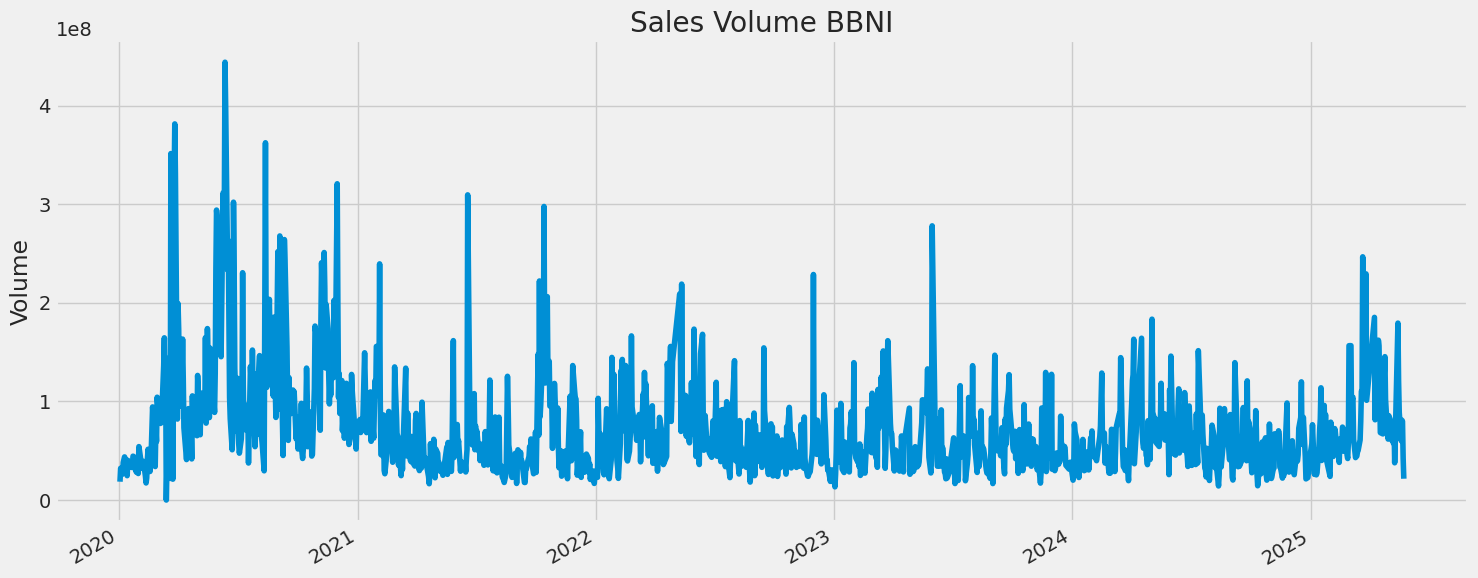

In [ ]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume BBNI")
plt.tight_layout()
plt.show()

## 3.Preprocessing data

Mengambil data harga penutupan dari DataFrame, mengubahnya menjadi array NumPy, dan kemudian membentuk kembali (reshape) array tersebut menjadi array 2D dengan satu kolom.

In [ ]:
# Memuat data
prices = df['Close'].values.reshape(-1, 1)

In [ ]:
prices

array([[3087.43212891],
       [3097.35986328],
       [3027.86743164],
       ...,
       [4520.        ],
       [4470.        ],
       [4510.        ]])

In [ ]:
prices.shape

(1299, 1)

In [ ]:
# Menormalkan data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

In [ ]:
# Membagi data menjadi data latih dan data uji 75:25
train_size = int(len(scaled_prices) * .75)
test_size = len(prices) - train_size

train_data = scaled_prices[ :train_size , 0:1 ]
test_data = scaled_prices[ train_size-60: , 0:1 ]

In [ ]:
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 974 Test Size : 325


In [ ]:
train_data.shape, test_data.shape

((974, 1), (385, 1))

mentiapkan input-output time series window = 60 hari untuk LSTM

In [ ]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

ubah data menjadi 3dimensi

In [ ]:
#ubah numpy ke aray
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#reshape input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
x_train.shape , y_train.shape

((914, 60, 1), (914,))

## 4. Build model

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)),

    LSTM(64, return_sequences=False),

    Dense(32),
    Dense(16),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=["mean_absolute_error"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0531 - mean_absolute_error: 0.1686
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0026 - mean_absolute_error: 0.0406
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 9.1878e-04 - mean_absolute_error: 0.0231
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0010 - mean_absolute_error: 0.0239
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 9.3835e-04 - mean_absolute_error: 0.0233
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 9.4756e-04 - mean_absolute_error: 0.0232
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 8.9188e-04 - mean_absolute_error: 0.0225
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 8.7591e-04 - mean_absolute_error: 0.0226
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 8.2232e-04 - mean_absolute_error: 0.0218
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 8.1713e-04 - mean_absolute_error: 0.0215
E

## 5. Evaluasi

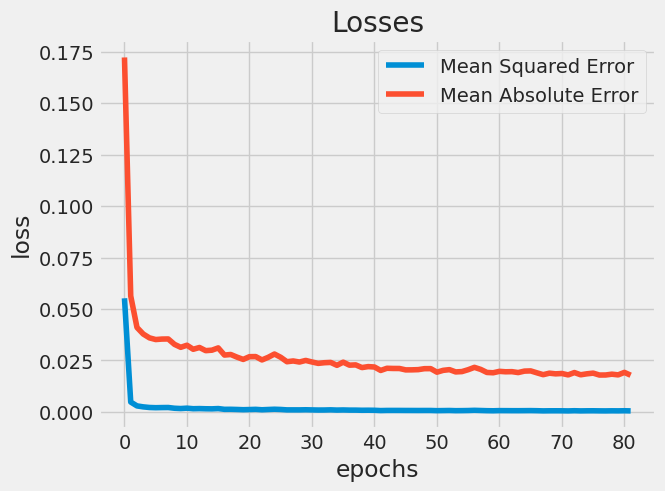

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_test.shape , y_test.shape

((325, 60, 1), (325,))

In [ ]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


(325, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

np.float64(86.45)

forecast next 30 days

In [ ]:
from datetime import timedelta

In [ ]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [ ]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0])
    print(forcast)
    Xin = insert_end(Xin, out[0, 0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[np.float32(0.7455052)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[np.float32(0.7455052), np.float32(0.73719484)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[np.float32(0.7455052), np.float32(0.73719484), np.float32(0.72637427)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[np.float32(0.7455052), np.float32(0.73719484), np.float32(0.72637427), np.float32(0.7146598)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[np.float32(0.7455052), np.float32(0.73719484), np.float32(0.72637427), np.float32(0.7146598), np.float32(0.70334035)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[np.float32(0.7455052), np.float32(0.73719484), np.float32(0.72637427), np.float32(0.7146598), np.float32(0.70334035), np.float32(0.69267535)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[np.float32(0.7455052), np.float32(0.73719484), np.float32(0.72637427), np.float32(0.7146598), np.float32(0.70334035), np.float32(0.69267535), np.float32(0.6831496)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[np.float32(0.7455052), np.fl

In [ ]:
forcasted_output = np.asanyarray(forcast)
forcasted_output = forcasted_output.reshape(-1, 1)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [ ]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [ ]:
df_result

,Date,Forecasted
0,2025-05-23 00:00:00+07:00,4400.096680
1,2025-05-24 00:00:00+07:00,4365.458496
2,2025-05-25 00:00:00+07:00,4320.357422
3,2025-05-26 00:00:00+07:00,4271.530762
4,2025-05-27 00:00:00+07:00,4224.351074
5,2025-05-28 00:00:00+07:00,4179.898438
6,2025-05-29 00:00:00+07:00,4140.194336
7,2025-05-30 00:00:00+07:00,4105.887207
8,2025-05-31 00:00:00+07:00,4076.781006
9,2025-06-01 00:00:00+07:00,4052.435303


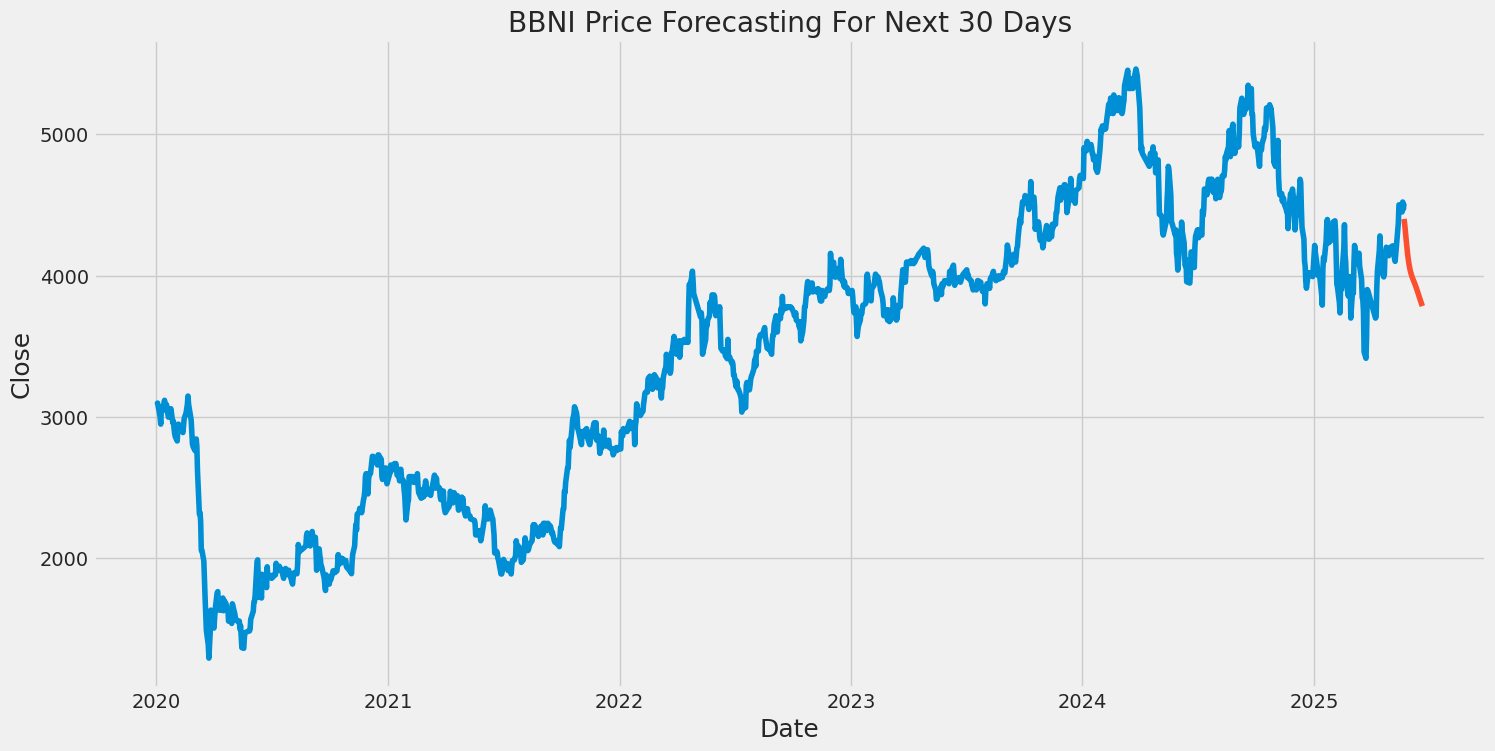

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('BBNI Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])

In [ ]:
model.save('model_lstm.h5')

In [ ]:
import joblib
joblib.dump(scaler, 'scaler_lstm.save')


['scaler_lstm.save']